# **US Tornados Data Analysis**
## *Tornados in the US from 1950 to 2021*
### By: Luke Sullivan
### Date: 22 April 2024

Dataset used: [US Tornado Dataset 1950-2021](https://www.kaggle.com/datasets/danbraswell/us-tornado-dataset-1950-2021?resource=download">https://www.kaggle.com/datasets/danbraswell/us-tornado-dataset-1950-2021)

---
**Dataset Definitions**

This dataset was derived from a dataset produced by National Oceanic and Atmospheric Administration (NOAA) Storm Prediction Center.

<p style="text-align:center"><b>The dataset contains the following columns:</b></p>

| Header | Description |
| ----------| ---------|
| yr | 4-digit year |
| mo | Month (1-12) |
| dy | Day of month |
| date | Datetime object (e.g. 2020-01-01)
| st | State where tornado originated |
| mag | Enhanced Fujita Scale rating |
| inj | Number of injuries |
| fat | Number of fatalities |
| slat | Starting latitude |
| slon | Starting longitude |
| elat | Ending latitude |
| elon | Ending longitude |
| len | length of track (mi) |
| wid | Width (yds) |

**The Enhanced Fujita Scale**

A tornado's destructiveness is derived largely from teh wind speed within it. Meteorologists use this Enhanced Fujita Scale since 2007 to rate tornadoes based on wind speed.

| Rate | Wind Speed | Damage |
| ----------| ---------| --------- |
| EF0 | 65-85 mph | Light damage |
| EF1 | 86-110 mph |  Moderate damage |
| EF2 | 111-135 mph | Considerable damage |
| EF3 | 136–165 mph | Severe damage |
| EF4 | 166–200 mph | Devastating damage |
| EF5 | >200 mph | Incredible damage |

# Research Questions
1. Have tornados increased or decreased over the years?
2. What states have the highest amount of tornados based on magnitude?
3. Are there trends in the traveled distance of the tornados?
4. How does the length and width of the tornado affect the injuries and fatalities?

In [1]:
#imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import zscore
from scipy.stats import mstats
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler, RobustScaler
standard_scaler = RobustScaler()
label_encoder = LabelEncoder()

## Data Preprocessing

In [2]:
#load data in dataframe
data = pd.read_csv("us_tornado_dataset_1950_2021.csv");
data.head(3)

,yr,mo,dy,date,st,mag,inj,fat,slat,slon,elat,elon,len,wid
0,1950,1,3,1950-01-03,IL,3,3,0,39.10,-89.30,39.12,-89.23,3.6,130
1,1950,1,3,1950-01-03,MO,3,3,0,38.77,-90.22,38.83,-90.03,9.5,150
2,1950,1,3,1950-01-03,OH,1,1,0,40.88,-84.58,0.00,0.00,0.1,10


In [3]:
print("########DATA SHAPE########")
print(data.shape)
print("########DATA TYPES########")
print(data.dtypes)

########DATA SHAPE########
(67558, 14)
########DATA TYPES########
yr        int64
mo        int64
dy        int64
date     object
st       object
mag       int64
inj       int64
fat       int64
slat    float64
slon    float64
elat    float64
elon    float64
len     float64
wid       int64
dtype: object


In [4]:
print("########NULL VALUES########")
print(data.isnull().sum())

########NULL VALUES########
yr      0
mo      0
dy      0
date    0
st      0
mag     0
inj     0
fat     0
slat    0
slon    0
elat    0
elon    0
len     0
wid     0
dtype: int64


In [5]:
print("sLon:", data.slon[data.slon==0].count())
print("sLat:", data.slat[data.slat==0].count())

print("eLon:", data.elon[data.elon==0].count())
print("eLat:", data.elat[data.elat==0].count())

sLon: 0
sLat: 0
eLon: 26363
eLat: 26363


In [6]:
#Data says that magnitutde is filled with "-9" for unknown ratings.
print("Missing mag count:", data.mag[data.mag==-9].count())
print("Missing mag compared to total rows: ", data.mag[data.mag==-9].count() / data.shape[0])

Missing mag count: 605
Missing mag compared to total rows:  0.008955268065958139


In [7]:
data.query('mag == -9')

,yr,mo,dy,date,st,mag,inj,fat,slat,slon,elat,elon,len,wid
60343,2016,4,15,2016-04-15,CO,-9,0,0,38.3743,-102.8185,38.4299,-102.8225,3.85,150
60344,2016,4,15,2016-04-15,CO,-9,0,0,38.4046,-102.8083,38.4118,-102.8082,0.50,100
60345,2016,4,15,2016-04-15,CO,-9,0,0,38.4773,-102.7234,38.4944,-102.7191,1.20,100
60346,2016,4,15,2016-04-15,CO,-9,0,0,38.1773,-102.7907,38.1852,-102.7865,0.59,100
60480,2016,5,8,2016-05-08,OK,-9,0,0,34.5810,-98.0760,34.5810,-98.0530,1.30,40
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67417,2021,12,15,2021-12-15,IA,-9,0,0,41.9551,-95.5749,42.0074,-95.5266,4.39,50
67418,2021,12,15,2021-12-15,IA,-9,0,0,42.5620,-95.4050,42.5850,-95.3880,1.81,50
67419,2021,12,15,2021-12-15,IA,-9,0,0,42.2525,-94.6317,42.2708,-94.6236,1.33,40
67420,2021,12,15,2021-12-15,IA,-9,0,0,42.5797,-94.5775,42.5920,-94.5657,1.04,40


In [8]:
data['mag'] = data['mag'].replace(-9, 0)
data.query('mag == -9')

,yr,mo,dy,date,st,mag,inj,fat,slat,slon,elat,elon,len,wid


In [9]:
data['state_encoded'] = label_encoder.fit_transform(data['st'])
data.head(3)

,yr,mo,dy,date,st,mag,inj,fat,slat,slon,elat,elon,len,wid,state_encoded
0,1950,1,3,1950-01-03,IL,3,3,0,39.10,-89.30,39.12,-89.23,3.6,130,14
1,1950,1,3,1950-01-03,MO,3,3,0,38.77,-90.22,38.83,-90.03,9.5,150,24
2,1950,1,3,1950-01-03,OH,1,1,0,40.88,-84.58,0.00,0.00,0.1,10,35


In [10]:
data.describe()

,yr,mo,dy,mag,inj,fat,slat,slon,elat,elon,len,wid,state_encoded
count,67558.000000,67558.000000,67558.000000,67558.000000,67558.000000,67558.000000,67558.000000,67558.000000,67558.000000,67558.000000,67558.000000,67558.000000,67558.000000
mean,1991.341618,5.976761,15.921016,0.771870,1.437876,0.090470,37.142412,-92.784618,22.730695,-56.245590,3.478340,106.577030,25.327082
std,19.330015,2.438192,8.736773,0.896514,18.263956,1.484106,5.093979,8.689103,18.588638,45.489157,8.278775,205.802676,14.434335
min,1950.000000,1.000000,1.000000,0.000000,0.000000,0.000000,17.721200,-163.530000,0.000000,-163.530000,0.000000,0.000000,0.000000
25%,1976.000000,4.000000,8.000000,0.000000,0.000000,0.000000,33.220000,-98.450000,0.000000,-94.709800,0.100000,20.000000,14.000000
50%,1994.000000,6.000000,16.000000,1.000000,0.000000,0.000000,37.030000,-93.600000,32.480000,-84.420000,0.800000,50.000000,24.000000
75%,2008.000000,7.000000,24.000000,1.000000,0.000000,0.000000,40.930000,-86.730000,38.610000,0.000000,3.130000,100.000000,39.000000
max,2021.000000,12.000000,31.000000,5.000000,1740.000000,158.000000,61.020000,-64.715100,61.020000,0.000000,234.700000,4576.000000,52.000000


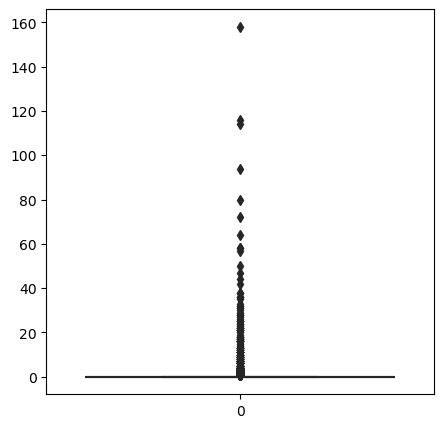

In [11]:
plt.figure(figsize=[5,5])
sns.boxplot(data['fat'], color='purple')
plt.show()

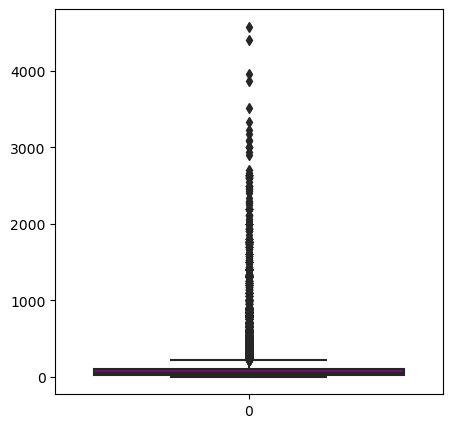

In [12]:
plt.figure(figsize=[5,5])
sns.boxplot(data['wid'], color='purple')
plt.show()

In [13]:
#data['len'] = mstats.winsorize(data['len'], limits=[0.05, 0.05])
#data['wid'] = mstats.winsorize(data['wid'], limits=[0.05, 0.05])
#data['inj'] = mstats.winsorize(data['inj'], limits=[0.05, 0.05])
#data['fat'] = mstats.winsorize(data['fat'], limits=[0.05, 0.05])

In [14]:
data.wid.unique()

array([ 130,  150,   10,   17,  100,  300,  133,  400,   67, 1000,   33,
        233,  833,   50,   27,  600,  200, 1760,   77,   37,  293,  440,
         30,  660,  467,  333,  250,   40,  880,  267,  700,  220,  167,
         90,   13,  500,  317,   20,  123,   73,  127,  900,  217,  450,
        173,  350,  330,  110,   57,  140,  230,  177,  587,  650,  417,
        427,   83,   60,   43, 1300,   70,  867,   80,  750,   23,   97,
        583,  433,  147,  667, 1417, 1320, 1480,   53,   47,  883,  137,
        210,  163,  800,  227, 1100,  790,  207,  223,   25,  313,  120,
         63,  367,  117, 1333,  533, 1200,  183, 1667,  320, 1500,  283,
        180,  280,  550,  187,  517, 2000,  817, 1400, 1600, 1167,  160,
        733,  327,  243,   87,  647,  527,  253,  143,  115,  277,   93,
       3000, 2667,  193, 2933,  360,  290, 2200, 1133, 2500,  213,  107,
       1700, 2630,  270, 1583,  373,  613,  850,  170,  420, 1056,  567,
        530, 1707, 1733, 2333,  847, 1533,  713, 10

In [15]:
standardize = data[['inj', 'fat', 'len', 'wid']]
other_data = data[['mag','yr', 'mo', 'dy', 'date', 'st', 'state_encoded', 'slat', 'slon', 'elat', 'elon']]
s_data = standard_scaler.fit_transform(standardize)
s_data = pd.concat([pd.DataFrame(s_data, columns=standardize.columns), other_data], axis=1)
dtype_dict = {'yr': 'int32', 'mo': 'int32', 'dy': 'int32'}
s_data.head()

,inj,fat,len,wid,mag,yr,mo,dy,date,st,state_encoded,slat,slon,elat,elon
0,3.0,0.0,0.924092,1.0000,3,1950,1,3,1950-01-03,IL,14,39.10,-89.30,39.12,-89.23
1,3.0,0.0,2.871287,1.2500,3,1950,1,3,1950-01-03,MO,24,38.77,-90.22,38.83,-90.03
2,1.0,0.0,-0.231023,-0.5000,1,1950,1,3,1950-01-03,OH,35,40.88,-84.58,0.00,0.00
3,1.0,1.0,-0.066007,-0.4125,3,1950,1,13,1950-01-13,AR,2,34.40,-94.37,0.00,0.00
4,0.0,0.0,-0.231023,0.6250,2,1950,1,25,1950-01-25,IL,14,41.17,-87.33,0.00,0.00


In [16]:
s_data.describe()

,inj,fat,len,wid,mag,yr,mo,dy,state_encoded,slat,slon,elat,elon
count,67558.000000,67558.000000,67558.000000,67558.000000,67558.000000,67558.000000,67558.000000,67558.000000,67558.000000,67558.000000,67558.000000,67558.000000,67558.000000
mean,1.437876,0.090470,0.883941,0.707213,0.771870,1991.341618,5.976761,15.921016,25.327082,37.142412,-92.784618,22.730695,-56.245590
std,18.263956,1.484106,2.732269,2.572533,0.896514,19.330015,2.438192,8.736773,14.434335,5.093979,8.689103,18.588638,45.489157
min,0.000000,0.000000,-0.264026,-0.625000,0.000000,1950.000000,1.000000,1.000000,0.000000,17.721200,-163.530000,0.000000,-163.530000
25%,0.000000,0.000000,-0.231023,-0.375000,0.000000,1976.000000,4.000000,8.000000,14.000000,33.220000,-98.450000,0.000000,-94.709800
50%,0.000000,0.000000,0.000000,0.000000,1.000000,1994.000000,6.000000,16.000000,24.000000,37.030000,-93.600000,32.480000,-84.420000
75%,0.000000,0.000000,0.768977,0.625000,1.000000,2008.000000,7.000000,24.000000,39.000000,40.930000,-86.730000,38.610000,0.000000
max,1740.000000,158.000000,77.194719,56.575000,5.000000,2021.000000,12.000000,31.000000,52.000000,61.020000,-64.715100,61.020000,0.000000


In [17]:
print(s_data.isnull().sum())
s_data = s_data.dropna()
print(s_data.isnull().sum())

inj              0
fat              0
len              0
wid              0
mag              0
yr               0
mo               0
dy               0
date             0
st               0
state_encoded    0
slat             0
slon             0
elat             0
elon             0
dtype: int64
inj              0
fat              0
len              0
wid              0
mag              0
yr               0
mo               0
dy               0
date             0
st               0
state_encoded    0
slat             0
slon             0
elat             0
elon             0
dtype: int64


In [18]:
s_data['yr'] = s_data['yr'].astype('int')
s_data['mo'] = s_data['mo'].astype('int')
s_data['dy'] = s_data['dy'].astype('int')
s_data.dtypes

inj              float64
fat              float64
len              float64
wid              float64
mag                int64
yr                 int32
mo                 int32
dy                 int32
date              object
st                object
state_encoded      int32
slat             float64
slon             float64
elat             float64
elon             float64
dtype: object

In [19]:
column_names = {'mag': 'Magnitude',
                'inj': 'Injuries',
                'fat': 'Deaths',
                'st': 'State',
                'len': 'Length',
                'wid': 'Width'}
data.rename(columns=column_names, inplace=True)
s_data.rename(columns=column_names, inplace=True)

In [20]:
data.head(10)

,yr,mo,dy,date,State,Magnitude,Injuries,Deaths,slat,slon,elat,elon,Length,Width,state_encoded
0,1950,1,3,1950-01-03,IL,3,3,0,39.10,-89.30,39.12,-89.23,3.6,130,14
1,1950,1,3,1950-01-03,MO,3,3,0,38.77,-90.22,38.83,-90.03,9.5,150,24
2,1950,1,3,1950-01-03,OH,1,1,0,40.88,-84.58,0.00,0.00,0.1,10,35
3,1950,1,13,1950-01-13,AR,3,1,1,34.40,-94.37,0.00,0.00,0.6,17,2
4,1950,1,25,1950-01-25,IL,2,0,0,41.17,-87.33,0.00,0.00,0.1,100,14
5,1950,1,25,1950-01-25,MO,2,5,0,37.60,-90.68,37.63,-90.65,2.3,300,24
6,1950,1,26,1950-01-26,TX,2,2,0,26.88,-98.12,26.88,-98.05,4.7,133,44
7,1950,2,11,1950-02-11,TX,2,0,0,29.42,-95.25,29.52,-95.13,9.9,400,44
8,1950,2,11,1950-02-11,TX,2,5,0,32.35,-95.20,32.42,-95.20,4.6,100,44
9,1950,2,11,1950-02-11,TX,2,6,0,32.98,-94.63,33.00,-94.70,4.5,67,44


In [21]:
##dataset 2
weather_data = pd.read_parquet('daily_weather.parquet')
weather_data.head()

,station_id,city_name,date,season,avg_temp_c,min_temp_c,max_temp_c,precipitation_mm,snow_depth_mm,avg_wind_dir_deg,avg_wind_speed_kmh,peak_wind_gust_kmh,avg_sea_level_pres_hpa,sunshine_total_min
0,41515,Asadabad,1957-07-01,Summer,27.0,21.1,35.6,0.0,NaN,NaN,NaN,NaN,NaN,NaN
1,41515,Asadabad,1957-07-02,Summer,22.8,18.9,32.2,0.0,NaN,NaN,NaN,NaN,NaN,NaN
2,41515,Asadabad,1957-07-03,Summer,24.3,16.7,35.6,1.0,NaN,NaN,NaN,NaN,NaN,NaN
3,41515,Asadabad,1957-07-04,Summer,26.6,16.1,37.8,4.1,NaN,NaN,NaN,NaN,NaN,NaN
4,41515,Asadabad,1957-07-05,Summer,30.8,20.0,41.7,0.0,NaN,NaN,NaN,NaN,NaN,NaN


In [22]:
city_data = pd.read_csv('weather_cities.csv')
city_data.head()

,station_id,city_name,country,state,iso2,iso3,latitude,longitude
0,41515,Asadabad,Afghanistan,Kunar,AF,AFG,34.866000,71.150005
1,38954,Fayzabad,Afghanistan,Badakhshan,AF,AFG,37.129761,70.579247
2,41560,Jalalabad,Afghanistan,Nangarhar,AF,AFG,34.441527,70.436103
3,38947,Kunduz,Afghanistan,Kunduz,AF,AFG,36.727951,68.872530
4,38987,Qala i Naw,Afghanistan,Badghis,AF,AFG,34.983000,63.133300


In [23]:
weather_data = pd.merge(weather_data, city_data, on='station_id', how='left')
weather_data.head()

,station_id,city_name_x,date,season,avg_temp_c,min_temp_c,max_temp_c,precipitation_mm,snow_depth_mm,avg_wind_dir_deg,...,peak_wind_gust_kmh,avg_sea_level_pres_hpa,sunshine_total_min,city_name_y,country,state,iso2,iso3,latitude,longitude
0,41515,Asadabad,1957-07-01,Summer,27.0,21.1,35.6,0.0,NaN,NaN,...,NaN,NaN,NaN,Asadabad,Afghanistan,Kunar,AF,AFG,34.866,71.150005
1,41515,Asadabad,1957-07-02,Summer,22.8,18.9,32.2,0.0,NaN,NaN,...,NaN,NaN,NaN,Asadabad,Afghanistan,Kunar,AF,AFG,34.866,71.150005
2,41515,Asadabad,1957-07-03,Summer,24.3,16.7,35.6,1.0,NaN,NaN,...,NaN,NaN,NaN,Asadabad,Afghanistan,Kunar,AF,AFG,34.866,71.150005
3,41515,Asadabad,1957-07-04,Summer,26.6,16.1,37.8,4.1,NaN,NaN,...,NaN,NaN,NaN,Asadabad,Afghanistan,Kunar,AF,AFG,34.866,71.150005
4,41515,Asadabad,1957-07-05,Summer,30.8,20.0,41.7,0.0,NaN,NaN,...,NaN,NaN,NaN,Asadabad,Afghanistan,Kunar,AF,AFG,34.866,71.150005


In [24]:
us_count = weather_data['country'].value_counts().get('United States of America', 0)
print(us_count)

1481287


In [25]:
weather_data = weather_data[weather_data['country'] == 'United States of America']
weather_data.head()

,station_id,city_name_x,date,season,avg_temp_c,min_temp_c,max_temp_c,precipitation_mm,snow_depth_mm,avg_wind_dir_deg,...,peak_wind_gust_kmh,avg_sea_level_pres_hpa,sunshine_total_min,city_name_y,country,state,iso2,iso3,latitude,longitude
25761028,72518,Albany,1938-06-01,Summer,NaN,8.3,26.7,0.0,0.0,NaN,...,NaN,NaN,NaN,Albany,United States of America,New York,US,USA,42.670017,-73.819949
25761029,72518,Albany,1938-06-02,Summer,NaN,9.4,26.1,5.1,0.0,NaN,...,NaN,NaN,NaN,Albany,United States of America,New York,US,USA,42.670017,-73.819949
25761030,72518,Albany,1938-06-03,Summer,NaN,13.9,23.3,4.1,0.0,NaN,...,NaN,NaN,NaN,Albany,United States of America,New York,US,USA,42.670017,-73.819949
25761031,72518,Albany,1938-06-04,Summer,NaN,9.4,25.0,0.0,0.0,NaN,...,NaN,NaN,NaN,Albany,United States of America,New York,US,USA,42.670017,-73.819949
25761032,72518,Albany,1938-06-05,Summer,NaN,13.3,22.2,0.0,0.0,NaN,...,NaN,NaN,NaN,Albany,United States of America,New York,US,USA,42.670017,-73.819949


In [26]:
print(weather_data.info())

<class 'pandas.core.frame.DataFrame'>
Index: 1481287 entries, 25761028 to 27242314
Data columns (total 21 columns):
 #   Column                  Non-Null Count    Dtype         
---  ------                  --------------    -----         
 0   station_id              1481287 non-null  object        
 1   city_name_x             1481287 non-null  category      
 2   date                    1481287 non-null  datetime64[us]
 3   season                  1481287 non-null  category      
 4   avg_temp_c              935601 non-null   float64       
 5   min_temp_c              1478703 non-null  float64       
 6   max_temp_c              1478761 non-null  float64       
 7   precipitation_mm        1458046 non-null  float64       
 8   snow_depth_mm           1303778 non-null  float64       
 9   avg_wind_dir_deg        456770 non-null   float64       
 10  avg_wind_speed_kmh      948369 non-null   float64       
 11  peak_wind_gust_kmh      432928 non-null   float64       
 12  avg_sea_lev

In [27]:
weather_data.shape

(1481287, 21)

In [28]:
weather_data.date.duplicated().sum()

1430272

In [29]:
data.State.unique()

array(['IL', 'MO', 'OH', 'AR', 'TX', 'LA', 'MS', 'TN', 'OK', 'FL', 'AL',
       'SC', 'KS', 'IA', 'NE', 'SD', 'WY', 'NC', 'GA', 'ND', 'MN', 'WI',
       'IN', 'PA', 'NM', 'CT', 'CO', 'WV', 'MD', 'KY', 'CA', 'VA', 'NJ',
       'MI', 'MA', 'NH', 'OR', 'NY', 'MT', 'AZ', 'UT', 'ME', 'VT', 'ID',
       'WA', 'DE', 'HI', 'PR', 'AK', 'NV', 'RI', 'DC', 'VI'], dtype=object)

In [30]:
state_mapping = {
    'Illinois': 'IL', 'Missouri': 'MO', 'Ohio': 'OH', 'Arkansas': 'AR', 'Texas': 'TX',
    'Louisiana': 'LA', 'Mississippi': 'MS', 'Tennessee': 'TN', 'Oklahoma': 'OK', 'Florida': 'FL',
    'Alabama': 'AL', 'South Carolina': 'SC', 'Kansas': 'KS', 'Iowa': 'IA', 'Nebraska': 'NE',
    'South Dakota': 'SD', 'Wyoming': 'WY', 'North Carolina': 'NC', 'Georgia': 'GA', 'North Dakota': 'ND',
    'Minnesota': 'MN', 'Wisconsin': 'WI', 'Indiana': 'IN', 'Pennsylvania': 'PA', 'New Mexico': 'NM',
    'Connecticut': 'CT', 'Colorado': 'CO', 'West Virginia': 'WV', 'Maryland': 'MD', 'Kentucky': 'KY',
    'California': 'CA', 'Virginia': 'VA', 'New Jersey': 'NJ', 'Michigan': 'MI', 'Massachusetts': 'MA',
    'New Hampshire': 'NH', 'Oregon': 'OR', 'New York': 'NY', 'Montana': 'MT', 'Arizona': 'AZ',
    'Utah': 'UT', 'Maine': 'ME', 'Vermont': 'VT', 'Idaho': 'ID', 'Washington': 'WA', 'Delaware': 'DE',
    'Hawaii': 'HI', 'Puerto Rico': 'PR', 'Alaska': 'AK', 'Nevada': 'NV', 'Rhode Island': 'RI',
    'District of Columbia': 'DC', 'Virgin Islands': 'VI'
}

weather_data['state'] = weather_data['state'].map(state_mapping)

In [31]:
weather_data.state.unique()

array(['NY', 'MD', 'GA', 'ME', 'TX', 'ND', 'ID', 'MA', 'NV', 'WV', 'WY',
       'SC', 'OH', 'NH', 'CO', 'IA', 'DE', 'KY', 'PA', 'CT', 'MT', 'HI',
       'IN', 'MS', 'MO', 'AK', 'MI', 'NE', 'AR', 'WI', 'AL', 'VT', 'TN',
       'OK', 'WA', 'AZ', 'RI', 'NC', 'VA', 'CA', 'MN', 'OR', 'UT', 'NM',
       'IL', 'FL', 'KS', 'NJ', 'DC'], dtype=object)

In [32]:
statechange = {'state': 'State'}
weather_data.rename(columns=statechange, inplace=True)
weather_data.head(1)

,station_id,city_name_x,date,season,avg_temp_c,min_temp_c,max_temp_c,precipitation_mm,snow_depth_mm,avg_wind_dir_deg,...,peak_wind_gust_kmh,avg_sea_level_pres_hpa,sunshine_total_min,city_name_y,country,State,iso2,iso3,latitude,longitude
25761028,72518,Albany,1938-06-01,Summer,NaN,8.3,26.7,0.0,0.0,NaN,...,NaN,NaN,NaN,Albany,United States of America,NY,US,USA,42.670017,-73.819949


In [33]:
data['date'] = pd.to_datetime(data['date'])

In [34]:
data.shape

(67558, 15)

In [35]:
tornado_data = pd.merge(data, weather_data, on=['date', 'State'], how='left')
tornado_data.shape

(67558, 34)

In [36]:
tornado_data.isnull().sum()

yr                            0
mo                            0
dy                            0
date                          0
State                         0
Magnitude                     0
Injuries                      0
Deaths                        0
slat                          0
slon                          0
elat                          0
elon                          0
Length                        0
Width                         0
state_encoded                 0
station_id                 6369
city_name_x                6369
season                     6369
avg_temp_c                23507
min_temp_c                 6373
max_temp_c                 6373
precipitation_mm           6734
snow_depth_mm             11010
avg_wind_dir_deg          43928
avg_wind_speed_kmh        20315
peak_wind_gust_kmh        47434
avg_sea_level_pres_hpa    31575
sunshine_total_min        39793
city_name_y                6369
country                    6369
iso2                       6369
iso3    

In [37]:
drop_columns = ['country', 'iso2', 'iso3', 'latitude', 'longitude']
tornado_data.drop(columns=drop_columns, inplace=True)

In [38]:
tornado_data.head()

,yr,mo,dy,date,State,Magnitude,Injuries,Deaths,slat,slon,...,min_temp_c,max_temp_c,precipitation_mm,snow_depth_mm,avg_wind_dir_deg,avg_wind_speed_kmh,peak_wind_gust_kmh,avg_sea_level_pres_hpa,sunshine_total_min,city_name_y
0,1950,1,3,1950-01-03,IL,3,3,0,39.10,-89.30,...,-6.1,15.6,31.5,0.0,NaN,NaN,NaN,NaN,NaN,Springfield
1,1950,1,3,1950-01-03,MO,3,3,0,38.77,-90.22,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1950,1,3,1950-01-03,OH,1,1,0,40.88,-84.58,...,11.7,17.8,17.5,0.0,195.0,27.5,NaN,1008.8,NaN,Columbus
3,1950,1,13,1950-01-13,AR,3,1,1,34.40,-94.37,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1950,1,25,1950-01-25,IL,2,0,0,41.17,-87.33,...,-2.8,21.1,19.6,0.0,NaN,NaN,NaN,NaN,NaN,Springfield


## Data Exploration
---

### Have tornados increased or decreased over the years?

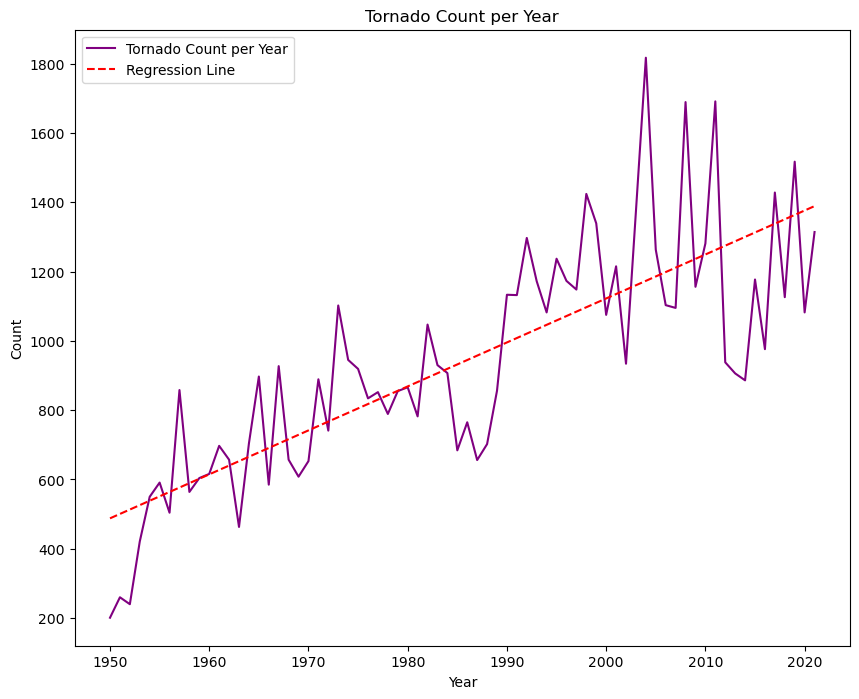

In [106]:
tornado_count = s_data.groupby('yr').Magnitude.count()

# Extract x and y values for plotting
x = tornado_count.index.values
y = tornado_count.values

# Fit a first-degree polynomial (linear regression) to the data
slope, intercept = np.polyfit(x, y, 1)

plt.figure(figsize=[10, 8])
plt.plot(x, y, color="purple", label='Tornado Count per Year')
plt.plot(x, slope * x + intercept, color="red", linestyle='--', label='Regression Line')  # Plot the regression line
plt.title('Tornado Count per Year')
plt.xlabel('Year')
plt.ylabel('Count')
plt.legend()
plt.show()

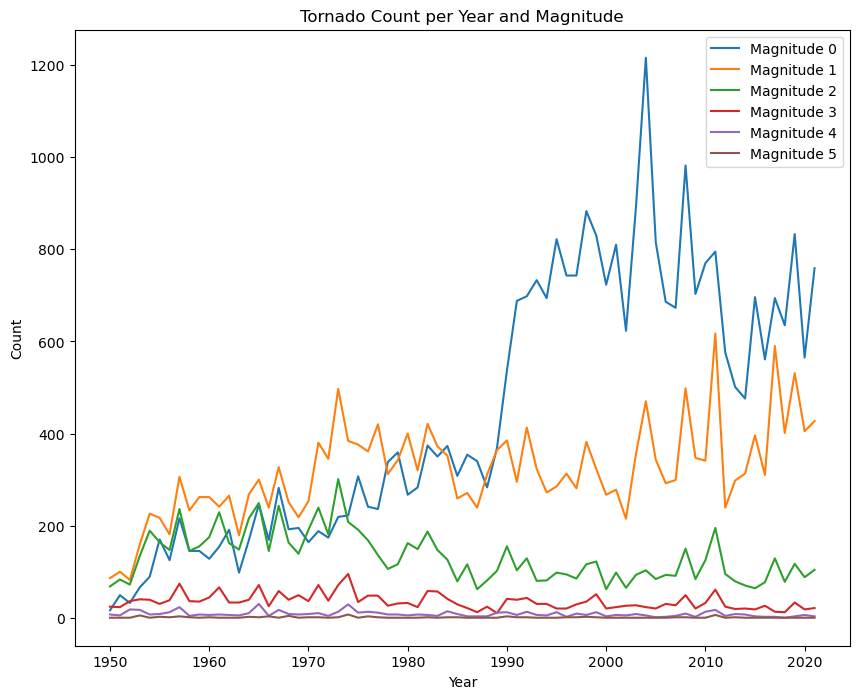

In [31]:
tornado_counts = s_data.groupby(['yr', 'Magnitude']).size().unstack(fill_value=0)

# Extract x values (years)
x = tornado_counts.index.values

# Create the plot
plt.figure(figsize=[10, 8])

# Plot each magnitude level as a separate line
for magnitude in range(0, 6):
    y = tornado_counts[magnitude].values
    plt.plot(x, y, label=f'Magnitude {magnitude}')

# Add legend, title, and labels
plt.title('Tornado Count per Year and Magnitude')
plt.xlabel('Year')
plt.ylabel('Count')
plt.legend()
plt.show()

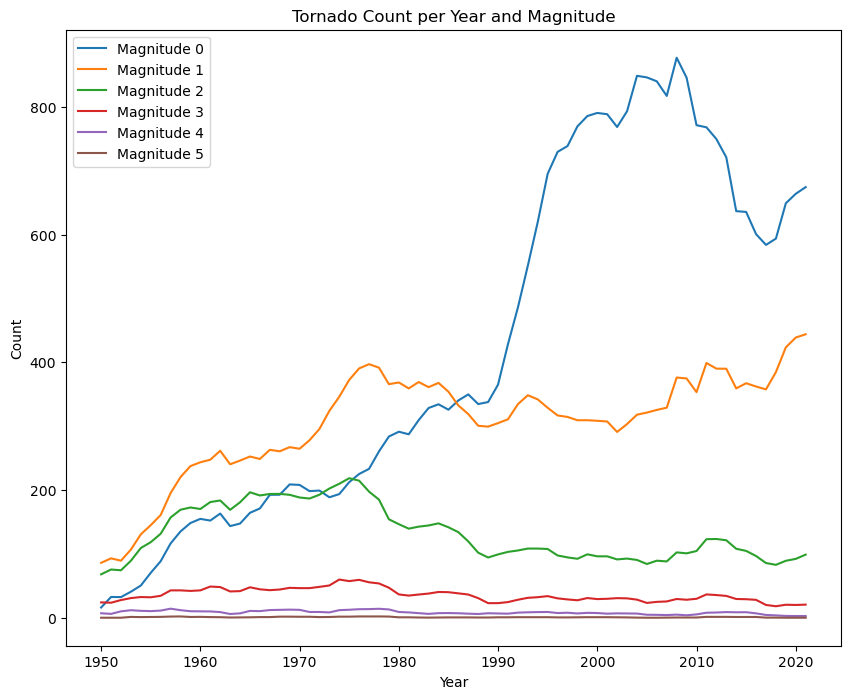

In [32]:
rolling_avg = tornado_counts.rolling(window=6, min_periods=1).mean()

x = rolling_avg.index.values

plt.figure(figsize=[10, 8])

# Plot each magnitude level as a separate line
for magnitude in range(0, 6):
    y = rolling_avg[magnitude].values
    plt.plot(x, y, label=f'Magnitude {magnitude}')

# Add legend, title, and labels
plt.title('Tornado Count per Year and Magnitude')
plt.xlabel('Year')
plt.ylabel('Count')
plt.legend()
plt.show()